# Entrenamiento y pronóstico

Vamos a entrenar 3 modelos para predecir el delta de temperatura.

- LSTM
- GRU
- Transformer


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from colores import colores

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2025-12-09 22:15:55.189099: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Los datos se encuentran en la carpeta csv:
- ts_imputado_*: las LST de los 5 años, para pino y para estepa, con los faltantes ya imputados por diferentes métodos.

In [3]:
# Temperaturas diurnas (diarias)
df_d_diaria = pd.read_csv("csv/ts_imputado_time.csv", parse_dates=["fecha"],
    dtype={"pino": "float64",
           "estepa": "float64",
           "mes": "int64",
           "delta": "float64"
          })

df_d_diaria.head(10)

,fecha,estepa,pino,mes,delta
0,2020-01-01,35.433453,33.666374,1,1.767079
1,2020-01-02,36.195872,31.342840,1,4.853032
2,2020-01-03,35.245773,31.284172,1,3.961601
3,2020-01-04,38.821326,31.450303,1,7.371023
4,2020-01-05,34.411211,17.944593,1,10.151255
5,2020-01-06,30.001096,18.733816,1,10.151255
6,2020-01-07,25.590980,19.523039,1,6.067942
7,2020-01-08,26.210976,20.506064,1,5.704912
8,2020-01-09,26.830971,21.489089,1,5.341882
9,2020-01-10,27.450967,22.472114,1,4.978853


---
## Preparación de datos para entrenamiento

Se entrenarán modelos para estimar el delta de temperatura diarias diurna

In [4]:
df_serie = df_d_diaria[['fecha','delta']] # datos diarios sin gaps

df_serie = df_serie.set_index('fecha')
df_serie.index = pd.to_datetime(df_serie.index)
df_serie.head()

,delta
fecha,
2020-01-01,1.767079
2020-01-02,4.853032
2020-01-03,3.961601
2020-01-04,7.371023
2020-01-05,10.151255


#### Split train y test

In [5]:
train_size = int(len(df_serie) * 0.8)  # 80 % entrenamiento, 20 % test
train_size # puntos

1461

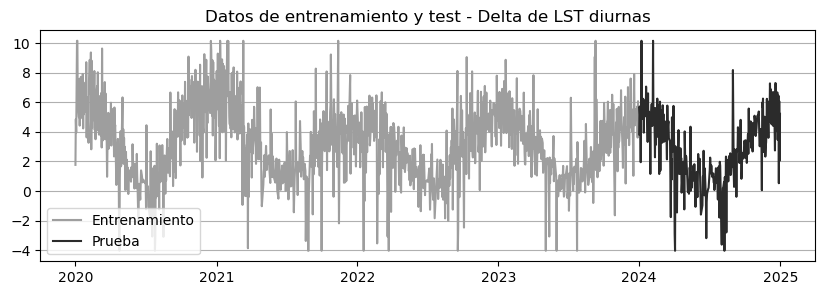

In [6]:
train = df_serie['delta'].iloc[:train_size]
test = df_serie['delta'].iloc[train_size:]

plt.figure(figsize=(10, 3))
plt.plot(train, label='Entrenamiento', color=colores['train'])
plt.plot(test, label='Prueba', color=colores['test'])
plt.legend(loc='lower left')

plt.grid(axis='y')
plt.title('Datos de entrenamiento y test - Delta de LST diurnas')
plt.show()

In [7]:
# Cuántos datos hay por año?
train.groupby(train.index.year).count()

fecha
2020    366
2021    365
2022    365
2023    365
Name: delta, dtype: int64

In [8]:
test.groupby(test.index.year).count()

fecha
2024    366
Name: delta, dtype: int64

#### Split

In [9]:
# función para crear secuencias
def create_sequences(data, seq_length, target_idx=0):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_idx])
    return np.array(X), np.array(y)


In [10]:
# Escala
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(df_serie['delta'].values.reshape(-1,1))

# Crea secuencias sobre toda la serie
seq_length = 182 # medio año
X, y = create_sequences(data_scaled, seq_length=seq_length)

test_points = 366  # 1 año

# convertir puntos a número de secuencias
test_sequences = test_points
train_sequences = len(X) - test_sequences

X_train, y_train = X[:train_sequences], y[:train_sequences]
X_test,  y_test  = X[train_sequences:], y[train_sequences:]

In [11]:
# Índices y variables auxiliares para los plots

# train_size_sec = cantidad de secuencias del train
train_size_sec = len(X_train)          # => 1279
# posición real en la serie original
train_end_real = train_size_sec + seq_length  # 1279 + 182 = 1461

offset = train_end_real  # 1461
index_train = df_serie.index[:offset]
index_test = df_serie.index[offset:]
index_forecast = df_serie.index[offset : offset + len(X_test)]
datos_train = df_serie['delta'].iloc[:offset]
datos_test = df_serie['delta'].iloc[offset:]


---
## Entrenamiento

In [12]:
def guardar_estadisticas( modelo, mae, mse, rmse, imprimir=True):
    if modelo in df_resultados['Modelo'].values:
        df_resultados.loc[df_resultados['Modelo'] == modelo, [ 'MAE', 'MSE', 'RMSE']] = [mae, mse, rmse]
    else:
        df_resultados.loc[len(df_resultados)] = [modelo, mae, mse, rmse]
    if imprimir:
        print(f"modelo {modelo}")
        print(f"MAE  : {mae:.4f}")
        print(f"MSE  : {mse:.4f}")
        print(f"RMSE : {rmse:.4f}")

# Dataframe para guardar los resultados
df_resultados = pd.DataFrame(columns=['Modelo', 'MAE', 'MSE', 'RMSE'])

### Modelo baseline: seasonal naive LAG-365

Predice el mismo valor del año anterior.

In [13]:
pred_seasonal = datos_train[-365:].values  # toma los últimos 365 del train como "ciclo anterior"
pred_seasonal = np.roll(pred_seasonal, -1)[:len(datos_test)]
pred_seasonal_rec = []
full_series = np.concatenate([datos_train.values, datos_test.values])  # para indexar
train_len = len(datos_train)
for i in range(len(datos_test)):
    pred_seasonal_rec.append(full_series[train_len + i - 365])

# Calcula métricas de error
mae = mean_absolute_error(datos_test, pred_seasonal_rec)
mse = mean_squared_error(datos_test, pred_seasonal_rec)
rmse = np.sqrt(mse)

guardar_estadisticas('NAIVE',mae, mse, rmse)

modelo NAIVE
MAE  : 1.6197
MSE  : 4.8209
RMSE : 2.1956


### a) LSTM

El modelo LSTM (Long Short-Term Memory) es un tipo de red neuronal recurrente diseñada para capturar dependencias de largo plazo en series temporales. LSTM no requiere que la serie sea estacionaria y puede aprender patrones complejos no lineales en los datos, incluyendo tendencias, estacionalidades y efectos de interacciones pasadas.

In [14]:
# Modelo LSTM
input_shape = (seq_length, 1)
model = Sequential([
    Input(shape=input_shape),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dense(1)
])

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1) 


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0906 - val_loss: 0.0543
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0616 - val_loss: 0.0535
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 0.0702 - val_loss: 0.0533
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.0739 - val_loss: 0.0535
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0671 - val_loss: 0.0533
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0662 - val_loss: 0.0531
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0673 - val_loss: 0.0526
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0671 - val_loss: 0.0526
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0594 - val_loss: 0.0526
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0581 - val_loss: 0.0523
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0658 - val_loss: 0.0522
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step

In [15]:
# Generar pronósticos
forecast_scaled = model.predict(X_test)
forecast_lstm = scaler.inverse_transform(forecast_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


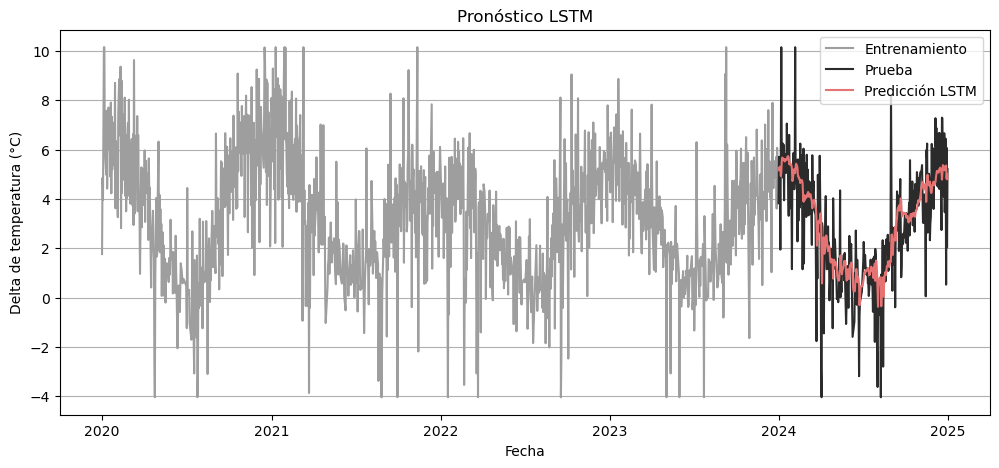

In [16]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_lstm, label="Predicción LSTM", color=colores['LSTM'])

plt.title('Pronóstico LSTM')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [17]:
# Calcular métricas de error

mae = mean_absolute_error(datos_test, forecast_lstm)
mse = mean_squared_error(datos_test, forecast_lstm)
rmse = np.sqrt(mse)

guardar_estadisticas('LSTM',mae, mse, rmse)

modelo LSTM
MAE  : 1.0594
MSE  : 2.2414
RMSE : 1.4971


### b) GRU

El modelo GRU (Gated Recurrent Unit) es una variante simplificada y más eficiente de la LSTM, también diseñada para modelar dependencias de largo plazo en series temporales. Utiliza solo dos compuertas (update y reset) en lugar de tres, lo que reduce significativamente el número de parámetros y acelera tanto el entrenamiento como la inferencia, manteniendo un rendimiento comparable o incluso superior en muchas tareas. Al igual que la LSTM, no necesita estacionariedad y aprende automáticamente tendencias, ciclos y relaciones no lineales complejas entre eventos pasados y futuros.

In [18]:
# Modelo GRU
input_shape = (seq_length, 1)
model = Sequential([
    Input(shape=input_shape),
    GRU(64, activation='tanh', return_sequences=True),
    Dropout(0.2),
    GRU(32, activation='tanh'),
    Dense(1)
])

# Compila el modelo
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Entrena el modelo
history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1) 


Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0785 - val_loss: 0.0530
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0628 - val_loss: 0.0540
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0598 - val_loss: 0.0527
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0634 - val_loss: 0.0524
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0597 - val_loss: 0.0522
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0631 - val_loss: 0.0521
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0608 - val_loss: 0.0525
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0674 - val_loss: 0.0514
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0679 - val_loss: 0.0515
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 0.0606 - val_loss: 0.0511
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0739 - val_loss: 0.0524
Epoch 12/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step

In [19]:
# Generar pronósticos
forecast_scaled = model.predict(X_test)
forecast_gru = scaler.inverse_transform(forecast_scaled)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


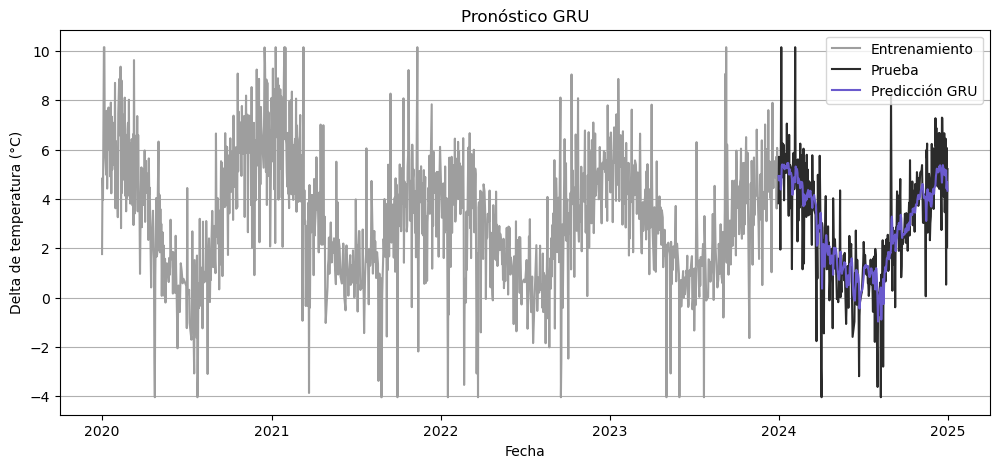

In [20]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_gru, label="Predicción GRU", color=colores['GRU'])

plt.title('Pronóstico GRU')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


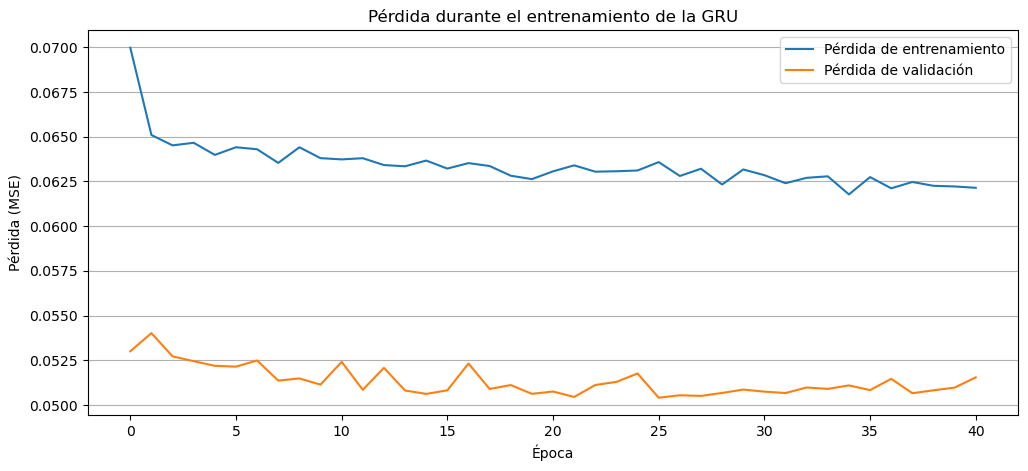

In [21]:
# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento de la GRU')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()


In [22]:
# Calcular métricas de error
mae = mean_absolute_error(datos_test, forecast_gru)
mse = mean_squared_error(datos_test, forecast_gru)
rmse = np.sqrt(mse)

guardar_estadisticas('GRU',mae, mse, rmse)

modelo GRU
MAE  : 1.0517
MSE  : 2.1813
RMSE : 1.4769


### c) Transformer

Los Transformers representan un cambio fundamental respecto LSTM y GRU en series temporales, porque eliminan la recurrencia y usan atención para capturar dependencias entre cualquier par de puntos en la secuencia, sin importar la distancia temporal. Son especialmente potentes para detectar patrones complejos, interacciones no locales y relaciones de múltiples escalas temporales (diarias, semanales, anuales) en una sola pasada.

In [23]:
class PositionalEncoding(layers.Layer):
    def __init__(self, seq_len, d_model):
        super().__init__()
        self.seq_len = seq_len
        self.d_model = d_model
        
        # Crea matriz de positional encoding (sinusoide fija)
        pe = np.zeros((seq_len, d_model))
        position = np.arange(0, seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        pe = pe[np.newaxis, ...]  # (1, seq_len, d_model)
        self.pe = tf.constant(pe, dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.pe[:, :tf.shape(inputs)[1], :]


def build_transformer(d_model=64, n_heads=4, n_layers=2, ff_dim=128, dropout=0.1):

    seq_length = X_train.shape[1]
    n_features = X_train.shape[2]

    inputs = Input(shape=(seq_length, n_features))
    
    # 1. Proyección lineal a d_model
    x = layers.Dense(d_model)(inputs)
    
    # 2. POSITIONAL ENCODING
    x = PositionalEncoding(seq_length, d_model)(x)
    
    # 3. Bloques Transformer
    for _ in range(n_layers):
        # Multi-Head Self Attention
        attn_output = layers.MultiHeadAttention(
            num_heads=n_heads, key_dim=d_model//n_heads, dropout=dropout
        )(x, x)
        attn_output = layers.Dropout(dropout)(attn_output)
        x1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        
        # Feed Forward
        ff = layers.Dense(ff_dim, activation='relu')(x1)
        ff = layers.Dense(d_model)(ff)
        ff = layers.Dropout(dropout)(ff)
        x = layers.LayerNormalization(epsilon=1e-6)(x1 + ff)
    
    # 4. Salida
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    
    model = Model(inputs, outputs)
    return model


model = build_transformer(
    d_model=64,
    n_heads=4,
    n_layers=2,
    ff_dim=128,
    dropout=0.1
)


model.compile(
    optimizer=Adam(learning_rate=0.0012),
    loss='huber',
    # loss='mse',
    metrics=['mae']
)


model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 182, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 182, 64)   │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 182, 64)   │          0 │ dense_2[0][0]     │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 182, 64)   │     16,640 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 182, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 182, 64)   │          0 │ positional_encod… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 182, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 182, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 182, 64)   │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 182, 64)   │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 182, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 182, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 182, 64)   │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 182, 64)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 182, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 182, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 182, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 182, 64)   │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 182, 64)   │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 182, 64)   │          0 │ layer_normalizat

 Total params: 67,137 (262.25 KB)

 Trainable params: 67,137 (262.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 253ms/step - loss: 0.2832 - mae: 0.6097 - val_loss: 0.0442 - val_mae: 0.2392
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 234ms/step - loss: 0.0564 - mae: 0.2643 - val_loss: 0.0314 - val_mae: 0.1851
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - loss: 0.0361 - mae: 0.2004 - val_loss: 0.0266 - val_mae: 0.1544
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 239ms/step - loss: 0.0350 - mae: 0.1958 - val_loss: 0.0263 - val_mae: 0.1542
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - loss: 0.0335 - mae: 0.1890 - val_loss: 0.0264 - val_mae: 0.1557
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 247ms/step - loss: 0.0414 - mae: 0.2167 - val_loss: 0.0315 - val_mae: 0.1766
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 232ms/step - loss: 0.0337 - mae: 0.1895 - val_loss: 0.0283 - val_mae: 0.1677
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 265ms/step - loss: 0.0375 - mae: 0.2019 - val_loss: 0.0386 - val_mae: 0.2112
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms

In [24]:
# Generar pronósticos
forecast_scaled = model.predict(X_test)
forecast_transf = scaler.inverse_transform(forecast_scaled.reshape(-1, 1)).ravel()


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step


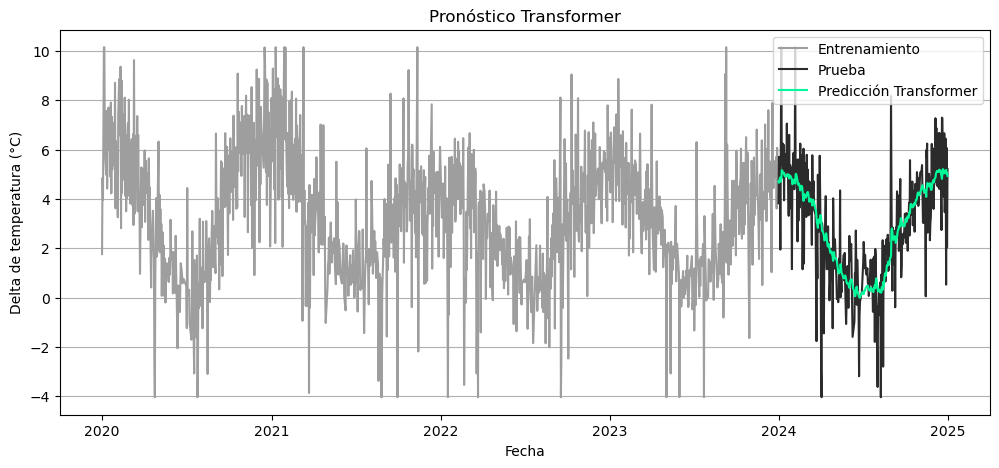

In [25]:
# Visualizar resultados

plt.figure(figsize=(12, 5))
plt.plot(index_train, datos_train, label="Entrenamiento", color=colores['train'])
plt.plot(index_test, datos_test, label="Prueba", color=colores['test'])
plt.plot(index_forecast, forecast_transf, label="Predicción Transformer", color=colores['TRANSFRMR'])

plt.title('Pronóstico Transformer')
plt.xlabel('Fecha')
plt.ylabel('Delta de temperatura (°C)')
plt.legend()
plt.grid(axis='y')
plt.show()


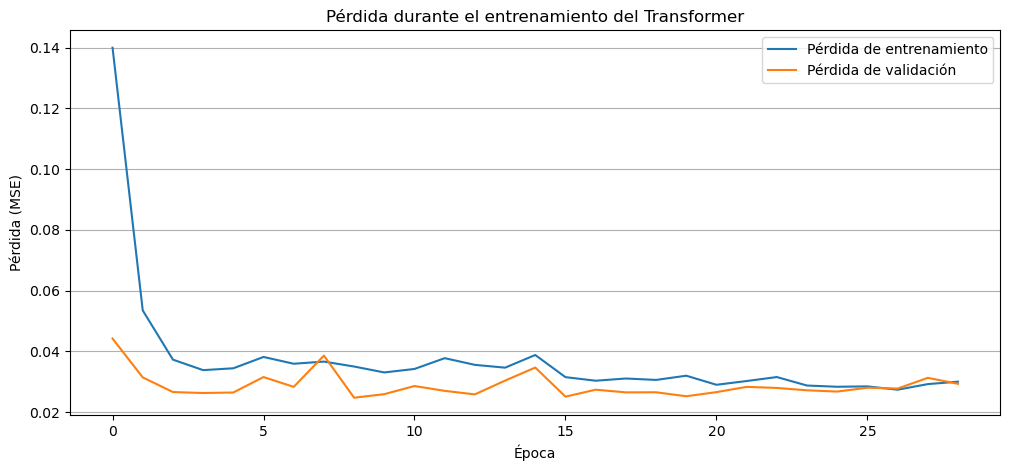

In [26]:
# Visualizar la pérdida durante el entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida durante el entrenamiento del Transformer')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(axis='y')
plt.show()

In [27]:
# Calcular métricas de error

mae = mean_absolute_error(datos_test, forecast_transf)
mse = mean_squared_error(datos_test, forecast_transf)
rmse = np.sqrt(mse)

guardar_estadisticas('TRANSFORMER',mae, mse, rmse)

modelo TRANSFORMER
MAE  : 1.0331
MSE  : 2.1444
RMSE : 1.4644


### Pronósticos (para todos los modelos)

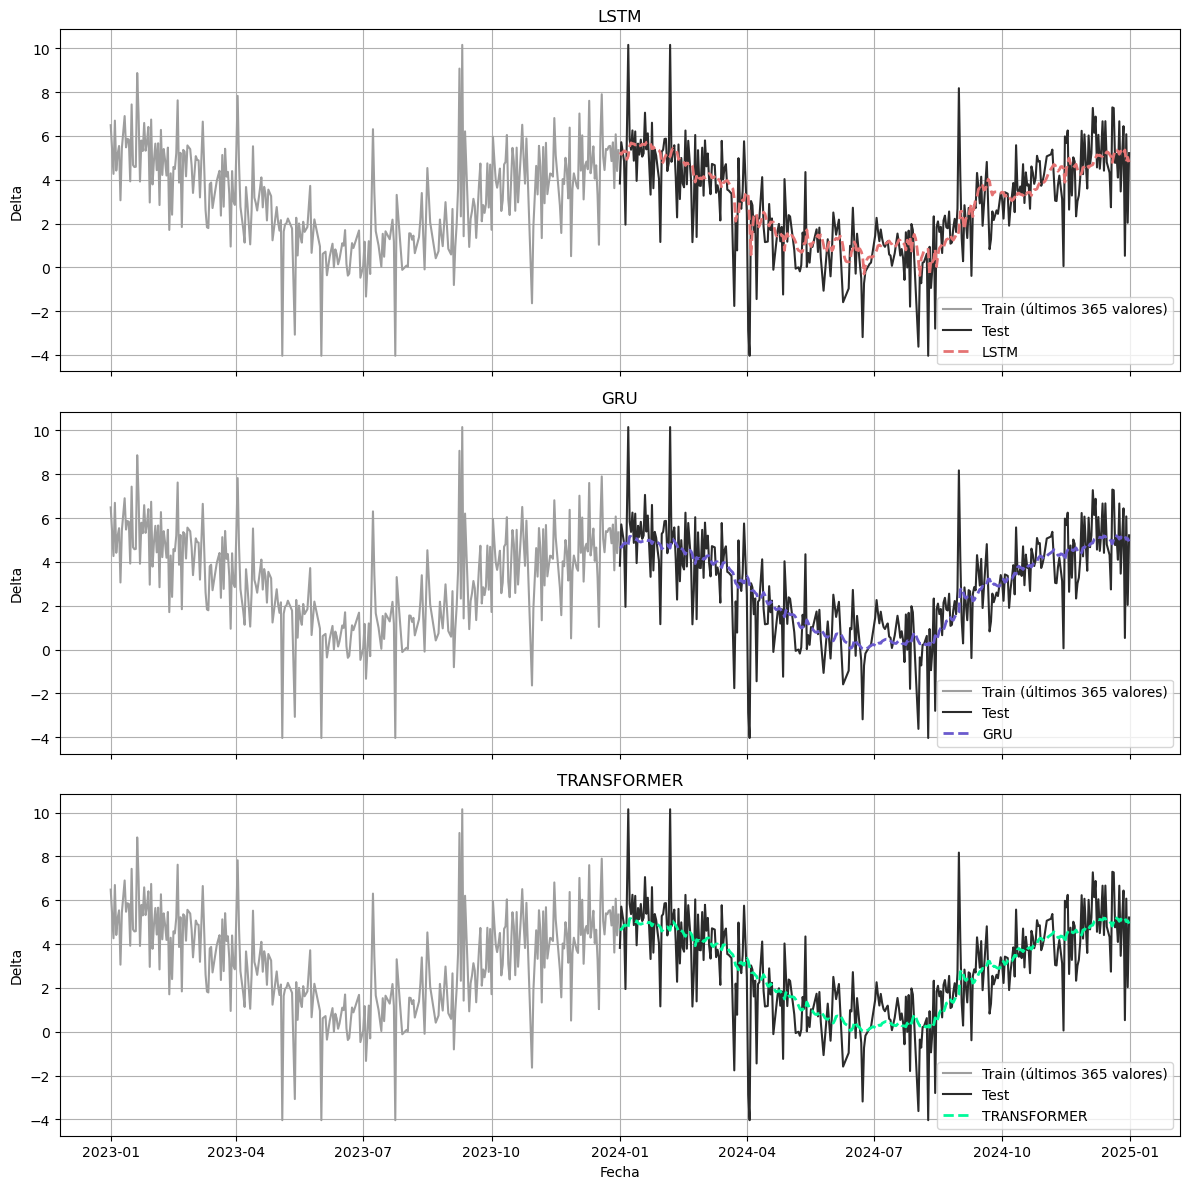

In [28]:
# Número de puntos históricos a mostrar
n_last = 365 # un año de datos
train_recent = train[-n_last:]

fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

# Lista de pronósticos y nombres
forecasts = [forecast_lstm, forecast_transf, forecast_transf]
names = ['LSTM', 'GRU', 'TRANSFORMER']
colors = [colores['LSTM'], colores['GRU'], colores['TRANSFRMR']]

for ax, forecast, name, color in zip(axes, forecasts, names, colors):
    # Plot train reciente
    ax.plot(train_recent.index, train_recent.values, label=f'Train (últimos {n_last} valores)', color=colores['train'])
    # Plot test
    ax.plot(test.index, test.values, label='Test', color=colores['test'])
    # Plot pronóstico
    ax.plot(test.index, forecast, label=name, linestyle='--', lw=2, color=color)

    ax.set_title(name)
    ax.set_ylabel('Delta')
    ax.legend()
    ax.grid(True)

axes[-1].set_xlabel('Fecha')
plt.tight_layout()
plt.show()


### Resultados

In [29]:
resultados = df_resultados.copy()
resultados.set_index('Modelo', inplace=True)
resultados

,MAE,MSE,RMSE
Modelo,,,
NAIVE,1.619709,4.820875,2.195649
LSTM,1.059387,2.241385,1.497126
GRU,1.051714,2.181286,1.476918
TRANSFORMER,1.033127,2.144376,1.464369


In [31]:
# antes (sin eliminar outliers)
#Modelo	#MAE	MSE	RMSE
#LSTM	1.090689	2.572154	1.603794
#GRU	1.084345	2.489980	1.577967
#TRANSFORMER	1.056740	2.432266	1.559572

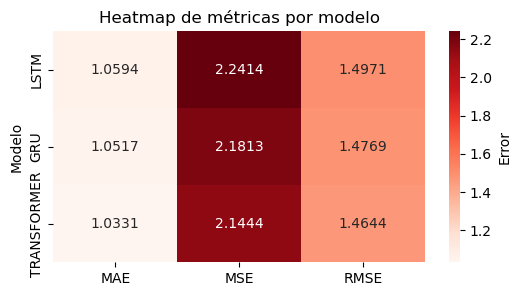

In [46]:
plt.figure(figsize=(6,3))
sns.heatmap(resultados.drop(index="NAIVE"), annot=True, fmt=".4f", cmap='Reds', cbar_kws={'label': 'Error'})
plt.title('Heatmap de métricas por modelo')
plt.show()


Para confirmar si las métricas son razonables, las comparamos en relación al modelo baseline.

In [52]:
mae_seasonal = resultados.loc['NAIVE']['MAE']
rmse_seasonal = resultados.loc['NAIVE']['RMSE']

df_resultados['Mejora vs Seasonal Naive (MAE)'] = (df_resultados['MAE'] - mae_seasonal) / mae_seasonal * 100
df_resultados['Mejora vs Seasonal Naive (RMSE)'] = (df_resultados['RMSE'] - rmse_seasonal) / rmse_seasonal * 100

df_resultados

,Modelo,MAE,MSE,RMSE,Mejora vs Seasonal Naive (MAE),Mejora vs Seasonal Naive (MSE),Mejora vs Seasonal Naive (RMSE)
0,NAIVE,1.619709,4.820875,2.195649,0.000000,0.000000,0.000000
1,LSTM,1.059387,2.241385,1.497126,-34.593986,-53.506676,-31.813987
2,GRU,1.051714,2.181286,1.476918,-35.067723,-54.753321,-32.734348
3,TRANSFORMER,1.033127,2.144376,1.464369,-36.215287,-55.518943,-33.305880


TODO A CHEQUEAR

Conclusiones

El baseline, Seasonal Naïve lag-365, da MAE = 1.62 °C y RMSE = 2.20 °C al predecir un año completo hacia adelante.

- Todos los modelos basados en redes profundas lo superan por un margen significante: reducción del MAE: 34.6 % – 36.2 % / Reducción del RMSE: 31.85 % – 33.3 %
- El Transformer es el ganador (MAE 1.03 °C y RMSE 1.46 °C).
- La diferencia GRU vs LSTM vs Transformer es pequeña pero consistente.